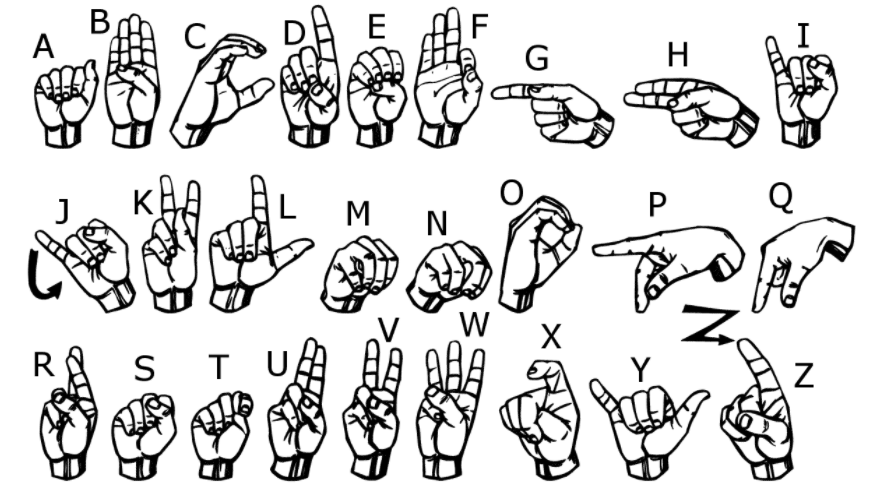

In [4]:
from IPython.display import Image
Image(filename='./archive/american_sign_language.PNG') 

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
for dirname, _, filenames in os.walk('./archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./archive/amer_sign2.png
./archive/american_sign_language.PNG
./archive/sign_mnist_train.csv
./archive/sign_mnist_test.csv
./archive/amer_sign3.png
./archive/sign_mnist_train/sign_mnist_train.csv
./archive/sign_mnist_test/sign_mnist_test.csv


In [6]:
data_raw = pd.read_csv('./archive/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('./archive/sign_mnist_test.csv', sep=",")

In [7]:
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

In [8]:
data = data_raw.values
labels = labels.values

test_data = test_data_raw.values
labels_test = labels_test.values

<AxesSubplot:>

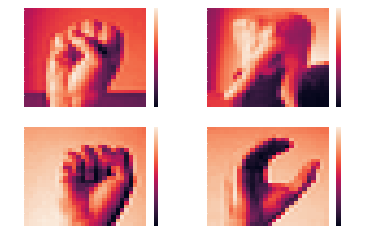

In [9]:
pixels = data[10].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)

pixels = data[12].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)

pixels = data[20].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)

pixels = data[32].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)

In [10]:
reshaped = []
for i in data:
    reshaped.append(i.reshape(1, 28, 28))
data = np.array(reshaped)

reshaped_test = []
for i in test_data:
    reshaped_test.append(i.reshape(1,28,28))
test_data = np.array(reshaped_test)

In [11]:
x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_x = torch.FloatTensor(test_data)
test_y = torch.LongTensor(labels_test.tolist())

In [12]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26)
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [14]:
#!pip install torch-summary
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = Network().to(device)
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          100
├─MaxPool2d: 1-2                         [-1, 10, 13, 13]          --
├─Conv2d: 1-3                            [-1, 20, 11, 11]          1,820
├─MaxPool2d: 1-4                         [-1, 20, 5, 5]            --
├─Conv2d: 1-5                            [-1, 30, 3, 3]            5,430
├─Dropout2d: 1-6                         [-1, 30, 3, 3]            --
├─Linear: 1-7                            [-1, 270]                 73,170
├─Linear: 1-8                            [-1, 26]                  7,046
├─LogSoftmax: 1-9                        [-1, 26]                  --
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.33
Estimated Total Size (MB): 0.41


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 26, 26]          100
├─MaxPool2d: 1-2                         [-1, 10, 13, 13]          --
├─Conv2d: 1-3                            [-1, 20, 11, 11]          1,820
├─MaxPool2d: 1-4                         [-1, 20, 5, 5]            --
├─Conv2d: 1-5                            [-1, 30, 3, 3]            5,430
├─Dropout2d: 1-6                         [-1, 30, 3, 3]            --
├─Linear: 1-7                            [-1, 270]                 73,170
├─Linear: 1-8                            [-1, 26]                  7,046
├─LogSoftmax: 1-9                        [-1, 26]                  --
Total params: 87,566
Trainable params: 87,566
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.33
Estimated Total Size (MB): 0.41

In [16]:
net = Network()

optimizer = optim.SGD(net.parameters(),0.001, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [17]:
loss_log = []
acc_log = []

for e in range(50):
    for i in range(0, x.shape[0], 100):
        x_mini = x[i:i + 100] 
        y_mini = y[i:i + 100] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_x[:500])).data, 1)[1], test_y[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.880412
Epoch: 2 - Loss: 2.336076
Epoch: 3 - Loss: 1.588991
Epoch: 4 - Loss: 1.407204
Epoch: 5 - Loss: 1.259710
Epoch: 6 - Loss: 1.081847
Epoch: 7 - Loss: 0.830499
Epoch: 8 - Loss: 0.838229
Epoch: 9 - Loss: 0.627893
Epoch: 10 - Loss: 0.648290
Epoch: 11 - Loss: 0.724905
Epoch: 12 - Loss: 0.568669
Epoch: 13 - Loss: 0.559346
Epoch: 14 - Loss: 0.399703
Epoch: 15 - Loss: 0.415475
Epoch: 16 - Loss: 0.625278
Epoch: 17 - Loss: 0.723644
Epoch: 18 - Loss: 0.502010
Epoch: 19 - Loss: 0.467725
Epoch: 20 - Loss: 0.439442
Epoch: 21 - Loss: 0.391478
Epoch: 22 - Loss: 0.383990
Epoch: 23 - Loss: 0.439389
Epoch: 24 - Loss: 0.384144
Epoch: 25 - Loss: 0.486433
Epoch: 26 - Loss: 0.374341
Epoch: 27 - Loss: 0.432213
Epoch: 28 - Loss: 0.446631
Epoch: 29 - Loss: 0.416084
Epoch: 30 - Loss: 0.357171
Epoch: 31 - Loss: 0.429135
Epoch: 32 - Loss: 0.398705
Epoch: 33 - Loss: 0.349979
Epoch: 34 - Loss: 0.412953
Epoch: 35 - Loss: 0.345487
Epoch: 36 - Loss: 0.373055
Epoch: 37 - Loss: 0.343117
Epoch: 38 

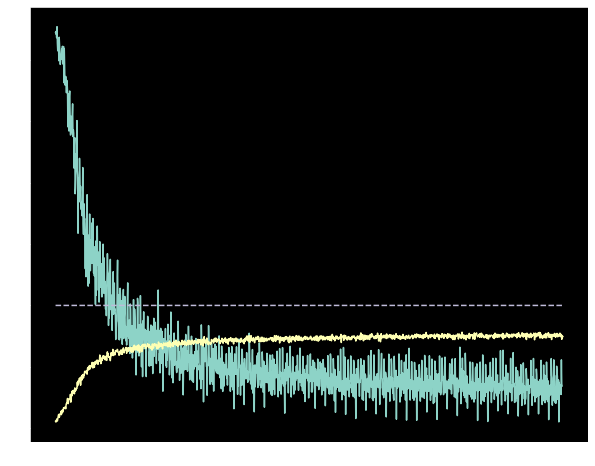

In [18]:
plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')
plt.show()

In [20]:
predictions = net(Variable(test_x))
net.test(torch.max(predictions.data, 1)[1], test_y)

Correct predictions:  5855 /  7172 (0.816369)
